<a href="https://colab.research.google.com/github/michaelhk101/Kaggle/blob/master/kaggle_Digit_Recognizer_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Competition - Digit Recognizer

This notebook is a submission to a kaggle competition: https://www.kaggle.com/c/digit-recognizer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cd drive/My\ Drive

# `cd` to the location of your jupyter notebook
!cd Colab\ Notebooks

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/bin/bash: line 0: cd: Colab Notebooks: No such file or directory


In [2]:
# To import kaggle datasets
!pip install kaggle

# import colab libraries
from google.colab import files

# import kaggle json to connect to kaggle user account to download datsets
files.upload()

# see if kaggle json exists
!ls -lha kaggle.json'

# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# download our dataset
!kaggle competitions download -c digit-recognizer --force

# unzip training set to `train` folder
!mkdir train
!unzip train.zip -d train

# unzip test set to `test` folder
!mkdir test
!unzip test.zip -d test

Saving kaggle.json to kaggle.json
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file
 94% 69.0M/73.2M [00:02<00:00, 12.1MB/s]
100% 73.2M/73.2M [00:02<00:00, 28.2MB/s]
 84% 41.0M/48.8M [00:01<00:00, 35.4MB/s]
100% 48.8M/48.8M [00:01<00:00, 38.8MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 77.8MB/s]
unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.
unzip:  cannot find or open test.zip, test.zip.zip or test.zip.ZIP.


# import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [2]:
training_data=pd.read_csv('train.csv')
testing_data=pd.read_csv('test.csv')

print("Training data:")
display(training_data.head())

print("Testing data:")
display(testing_data.head())


Training data:


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Testing data:


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We then reshape the data so that its shape is compatible with the keras CNN.

In [3]:
X_train_tmp,y_train_tmp=training_data.iloc[:,1:].values.reshape(-1,28,28,1),training_data.iloc[:,0]

X_test=testing_data.values.reshape(-1,28,28,1)

print('X_train_tmp.shape: ',X_train_tmp.shape)
print('y_train_tmp.shape: ',y_train_tmp.shape)
print('y_train_tmp')
print(y_train_tmp[:5])
print('X_test.shape: ',X_test.shape)

X_train_tmp.shape:  (42000, 28, 28, 1)
y_train_tmp.shape:  (42000,)
y_train_tmp
0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64
X_test.shape:  (28000, 28, 28, 1)


Have a look on some samples.

6 :


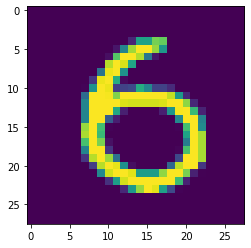

8 :


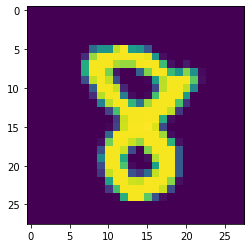

3 :


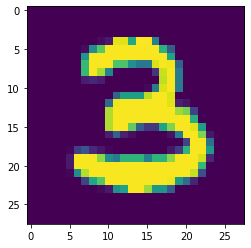

6 :


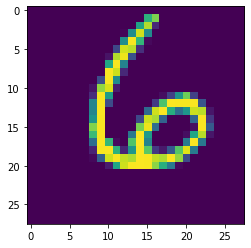

4 :


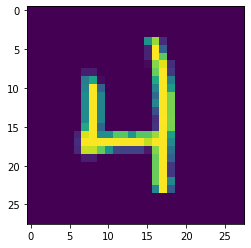

5 :


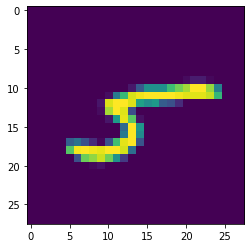

4 :


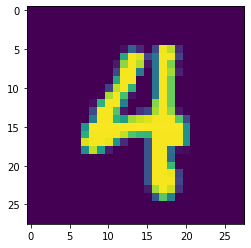

7 :


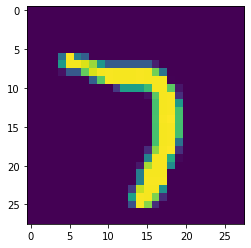

0 :


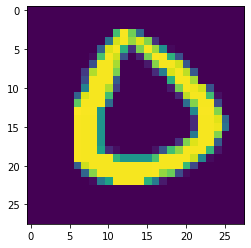

6 :


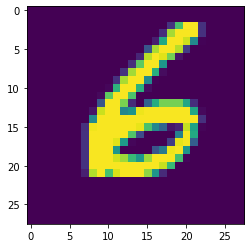

In [4]:
samples=np.random.randint(0, 42000, size=10)

for training_image_being_shown in samples:
  print(y_train_tmp[training_image_being_shown],":")
  plt.imshow(X_train_tmp[training_image_being_shown,:,:,0])
  plt.show()
  

Have a look on the distribution of labels:

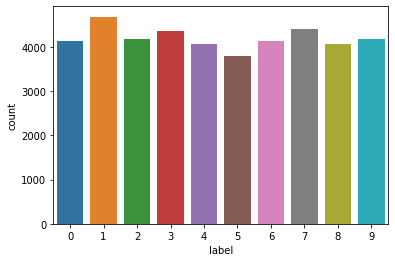

1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: label, dtype: float64

In [5]:
sns.countplot(y_train_tmp)
plt.show()
y_train_tmp.value_counts(normalize=True)

To get more data, we also import keras dataset

In [6]:
X_train,X_val,y_train,y_val=train_test_split(X_train_tmp,y_train_tmp,test_size=.1,stratify=y_train_tmp,random_state=42)
(X_train_1,y_train_1),(X_val_1,y_val_1)=mnist.load_data()
X_train=np.concatenate([X_train.reshape((-1,28,28,1)),X_train_1.reshape((-1,28,28,1))])
X_val=np.concatenate([X_val.reshape((-1,28,28,1)),X_val_1.reshape((-1,28,28,1))])

y_train=pd.DataFrame(np.concatenate([y_train,y_train_1]))
y_val=pd.DataFrame(np.concatenate([y_val,y_val_1]))

y_train.reset_index(drop=True,inplace=True)
y_val.reset_index(drop=True,inplace=True)

print('X_train.shape: ',X_train.shape)
print('y_train.shape: ',y_train.shape)
print('y_train: ')
print(y_train[:5])
print('X_val.shape: ',X_val.shape)
print('y_val.shape: ',y_val.shape)

11493376/11490434 [==============================] - 1s 0us/step
X_train.shape:  (97800, 28, 28, 1)
y_train.shape:  (97800, 1)
y_train: 
   0
0  3
1  8
2  0
3  8
4  7
X_val.shape:  (14200, 28, 28, 1)
y_val.shape:  (14200, 1)


To have more hand-written digits with different sizes and positions, we also use the technique of data augmentation.

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

# Model

We then define the CNN model. EarlyStopping and ReduceLROnPlateau are also used with the model so that the model will not be overfitted to the training set.

In [8]:
def MyCNN():
  model=Sequential()
  model.add(Conv2D(16,(5,5),input_shape=(28,28,1),activation='relu'))
  model.add(BatchNormalization())
  
  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(BatchNormalization())
  
  model.add(Conv2D(64,(2,2),activation='relu'))
  model.add(MaxPooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(.25))
  
  model.add(Conv2D(64,(2,2),activation='relu'))
  model.add(MaxPooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(.25))
  
  model.add(Conv2D(64,(2,2),activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(.25))
  
  model.add(Flatten())
  model.add(Dense(256,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(.25))
  model.add(Dense(10,activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
  display(model.summary())
  return model

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

early_stopping=EarlyStopping(monitor='val_acc', patience=10, verbose=1,)


model=MyCNN()















Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        9280      
_________________________________________________________________
batch_normalization_2 (Batch (None, 22, 22, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0 

None

The training data is fitted into the model with early_stopping and learning_rate_reduction defined in the previous cells being included in callbacks.

In [0]:
model.fit(X_train,y_train,epochs=600,callbacks=[early_stopping,learning_rate_reduction],batch_size=6000,validation_data=(X_val,y_val))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 97800 samples, validate on 14200 samples
Epoch 1/600
97800/97800 [==============================] - 25s 251us/step - loss: 0.9515 - acc: 0.7081 - val_loss: 0.2348 - val_acc: 0.9349
Epoch 2/600
97800/97800 [==============================] - 15s 155us/step - loss: 0.2129 - acc: 0.9328 - val_loss: 0.1236 - val_acc: 0.9655
Epoch 3/600
97800/97800 [==============================] - 15s 156us/step - loss: 0.1363 - acc: 0.9575 - val_loss: 0.0823 - val_acc: 0.9745
Epoch 4/600
97800/97800 [==============================] - 15s 156us/step - loss: 0.1092 - acc: 0.9660 - val_loss: 0.0618 - val_acc: 0.9804
Epoch 5/600
97800/97800 [==============================] - 15s 157us/step - loss: 0.0898 - acc: 0.9722 - val_loss: 0.0486 - val_acc: 0.9849
Epoch 6/600
97800/97800 [==============================] - 15s 157us/step - loss: 0.0779 - acc: 0.9757 - val_loss: 0.0437 - val_acc: 0.9863
Epoch 7/600
97

In [0]:
y_test_pred=model.predict_classes(X_test)
output=y_test_pred
y_test_df=pd.DataFrame({'ImageId':np.arange(1,len(y_test_pred)+1,1),'Label':output})
y_test_df.set_index('ImageId',inplace=True)
y_test_df.head()

In [0]:
y_test_df.to_csv('submission.csv')
pd.read_csv('submission.csv')

Submission to kaggle:

In [0]:
!kaggle competitions submit -c digit-recognizer -f submission.csv -m "Message"